In [2]:
import scipy.stats as stats
import os
import glob
import pandas as pd 
import numpy as np
import plotnine as p9
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
DIR=os.path.join("/NAS","dumbo","protocoles","GAITnPARK")

In [4]:
GnP_AMS=os.path.join(DIR,"Groups_GnP.xlsx")
GroupData = pd.read_excel(GnP_AMS,index_col=0,engine='openpyxl')

In [5]:
CSV_FILE=os.path.join(DIR,"volbrain2report.csv")
val = pd.read_csv(CSV_FILE,sep=';',index_col=0)

In [6]:
    list_col=['W0','W24','W48','Group']
    #sns.lineplot(data=DATA[DATA['Group']==4][list_col].T,palette='light:g',dashes=False)
    sns.violinplot(data=DATA[DATA['Group'].isin([1,4])][list_col],y="W24",inner="points",split=True,hue='Group')
    plt.legend().remove()
    plt.show()

NameError: name 'DATA' is not defined

Cerebellum total volume %


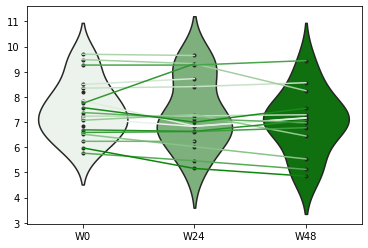

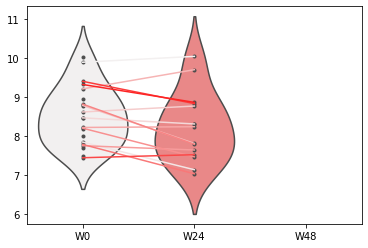

              sum_sq    df         F    PR(>F)
timepoint   1.233827   1.0  0.935814  0.336551
Residual   96.247009  73.0       NaN       NaN


/home/romain/.local/lib/python3.7/site-packages/pandas/core/frame.py:4301: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
for struct in ['Cerebellum total volume %']: #[col for col in val.columns if '%' in col and 'total' in col ]:
    print(struct)
    SES1=val.loc[[sub for sub in val.index if 'SES1' in sub]][struct]
    SES1.index=SES1.index.str.replace('T1_','')
    SES1.index=SES1.index.str.replace('_SES1$','')

    SES2=val.loc[[sub for sub in val.index if 'SES2' in sub]][struct]
    SES2.index=SES2.index.str.replace('T1_','')
    SES2.index=SES2.index.str.replace('_SES2$','')

    SES3=val.loc[[sub for sub in val.index if 'SES3' in sub]][struct]
    SES3.index=SES3.index.str.replace('T1_','')
    SES3.index=SES3.index.str.replace('_SES3$','')

    SES=pd.concat([SES1,SES2,SES3],keys=['W0', 'W24',"W48"],axis=1)
    SUBJ_Grp=GroupData['Group']
    DATA=pd.merge(GroupData,SES,left_index=True,right_index=True)

    list_col=['W0','W24','W48']
    sns.lineplot(data=DATA[DATA['Group']==4][list_col].T,palette='light:g',dashes=False)
    sns.violinplot(data=DATA[DATA['Group']==4][list_col], palette="light:g", inner="points")
    plt.legend().remove()
    plt.show()

    sns.lineplot(data=DATA[DATA['Group']==1][list_col].T,palette="light:r",dashes=False)
    sns.violinplot(data=DATA[DATA['Group']==1][list_col],palette="light:r",inner="points")
    plt.legend().remove()
    plt.show()

    df1=pd.merge(GroupData['Group'],SES1,left_index=True,right_index=True)
    df1['timepoint']="SES1"
    df2=pd.merge(GroupData['Group'],SES2,left_index=True,right_index=True)
    df2['timepoint']="SES2"
    tmp1=pd.concat([df1,df2])
    tmp2=tmp1[tmp1['Group'].isin([1,4])]
    tmp2.rename(columns={struct :'value'},inplace=True)
    model = ols('value ~ timepoint',data=tmp2).fit()
    anova_table = sm.stats.anova_lm(model,typ=2)
    print(anova_table)

## Nouvelle version du graphique 

/home/global/anaconda37/lib/python3.7/site-packages/seaborn/categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.


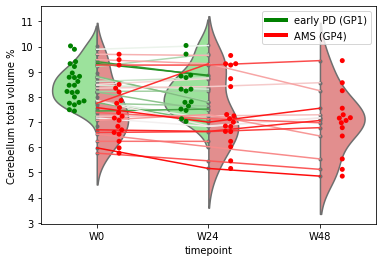

In [8]:
df1=pd.merge(GroupData['Group'],SES1,left_index=True,right_index=True)
df1['timepoint']="W0"
df2=pd.merge(GroupData['Group'],SES2,left_index=True,right_index=True)
df2['timepoint']="W24"
df3=pd.merge(GroupData['Group'],SES3,left_index=True,right_index=True)
df3['timepoint']="W48"
tmp1=pd.concat([df1,df2,df3])
tmp2=tmp1[tmp1['Group'].isin([1,4])]
#tmp2.rename(columns={struct :'value'},inplace=True)
list_col=['W0','W24','W48']
sns.lineplot(data=DATA[DATA['Group']==1][list_col].T,palette="light:g",dashes=False)
sns.lineplot(data=DATA[DATA['Group']==4][list_col].T,palette="light:r",dashes=False)
sns.violinplot(data=tmp2,x="timepoint",y="Cerebellum total volume %",inner="points",split=True,hue='Group',palette=['lightgreen','lightcoral'])
plt.legend(labels=['early PD (GP1)','AMS (GP4)'],loc='upper right')

sns.swarmplot(data=tmp2,x="timepoint",y="Cerebellum total volume %",split=True,hue='Group',palette=['green','red'])
#plt.legend().remove()
plt.legend(labels=['early PD (GP1)','AMS (GP4)'],handles=[
  plt.Line2D([0],[0],color='green',lw=4),
  plt.Line2D([0],[0],color='red',lw=4),
],loc='upper right')
plt.show()

## Modele lineaire mixte ne fonctionne pas (encore)

In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

tmplmdf=pd.concat([df1,df2])
tmplm=tmplmdf[tmplmdf['Group'].isin([1,4])]
tmplm=tmp2.rename(columns={struct :'value'})
#tmplm.rename_axis('SUBJ',inplace=True)
#tmplm['SUBJ']=tmplm.index.astype('category')
tmplm['timepoint']=tmplm['timepoint'].str.slice(start=1)
tmplm['timepoint']=tmplm['timepoint'].astype('float')
tmplm['Group']=tmplm['Group'].astype('category')

#model_formula = "value ~  Group + timepoint + (1 | Group)"
model_formula = "value ~  timepoint * Group"
#D'après DOrian model_formula = "value ~  timepoint * Group + (1 | SUBJ)"
model = smf.mixedlm(model_formula,data=tmplm, groups=tmp2['Group'])
result = model.fit()
print(result.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    value    
No. Observations:     89         Method:                REML     
No. Groups:           2          Scale:                 1.1911   
Min. group size:      37         Log-Likelihood:        -141.0270
Max. group size:      52         Converged:             Yes      
Mean group size:      44.5                                       
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               8.513    1.116  7.629 0.000  6.326 10.701
Group[T.4.0]           -0.968    1.577 -0.614 0.539 -4.059  2.123
timepoint              -0.012    0.015 -0.780 0.435 -0.042  0.018
timepoint:Group[T.4.0]  0.002    0.017  0.117 0.907 -0.032  0.036
Group Var               1.191                                    



/home/romain/.local/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.


In [16]:
tmplmdf

,Group,Cerebellum total volume %,timepoint
APPLINCOURT_MARIE_FRANCE,1.0,9.894493,W0
BEDEZ_DIDIER,1.0,7.841728,W0
BELHADJ_HACEN_ABDELHAMID,1.0,8.464046,W0
BELHADJ_HACEN_ABDELHAMID,1.0,8.464046,W0
BELLART_FRANCOIS,2.0,7.976713,W0
...,...,...,...
SARNA_JOSETTE,4.0,9.317901,W24
STASSART_MARC,1.0,8.862459,W24
VERNIER_CLAUDE,4.0,6.628456,W24
WATTENNE_VINCENT,4.0,6.995890,W24


tmp2

In [193]:
(DATA[DATA['Group']==1]['W24'].values - DATA[DATA['Group']==1]['W0'].values )/DATA[DATA['Group']==1]['W0'].values

array([ 0.00610794,  0.0102622 , -0.00140299, -0.00140299,  0.01514218,
        0.00259829,  0.01289597,  0.06402732, -0.00239879,  0.01232622,
        0.05531618, -0.00160761,         nan,         nan,         nan,
        0.05184486,  0.01769271,         nan,  0.028617  ,         nan,
               nan,         nan])

In [208]:
list_col=['W0','W24','Group']
DATA[DATA['Group'].isin([1,4])][list_col].dropna()

,W0,W24,Group
APPLINCOURT_MARIE_FRANCE,0.619120,0.622902,1
BEDEZ_DIDIER,0.622564,0.628953,1
BELHADJ_HACEN_ABDELHAMID,0.619857,0.618987,1
BELHADJ_HACEN_ABDELHAMID,0.619857,0.618987,1
BLANC_GARIN_FREDERIC,0.499424,0.537500,4
BOULY_HERVE,0.475868,0.479910,4
BRICHE_ANNE,0.582494,0.650912,4
BRISFER_JOEL,0.508931,0.516638,1
BUNIET_PASCAL,0.572469,0.585634,4
CARCAN_JACQUES,0.357434,0.361606,4


In [36]:
val = pd.read_csv(VOL_FILE,index_col=0,sep=',')
AMS_list=['BLANC_GARIN_FREDERIC','BOULY_HERVE','DALLOY_FREDERIQUE','DIETZINGER_GUY','ERIPRET_CATHERINE','GRAS_SYLVIANE','HUREZ_REGINE','LERMYTTE_NICOLE','SARNA_JOSETTE','WATTENNE_VINCENT','WU_SUQIN','BUNIET_PASCAL','CARCAN_JACQUES','COUDRON_PAULE','PROST_MARTINE','RABERANTO_MICHEL','VERNIER_CLAUDE']

In [45]:
from scipy import stats
t2, p2 = stats.wilcoxon(val.loc[AMS_list]['Baseline'].values,val.loc[AMS_list]['W24'].values)
print(t2,p2)

57.0 0.3778228759765625


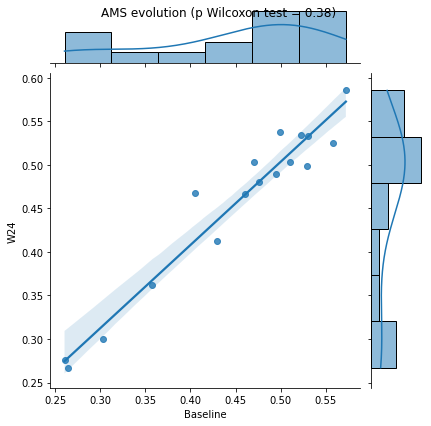

In [50]:
g = sns.jointplot(x="Baseline", y="W24",data=val.loc[AMS_list],kind="reg")
g.fig.suptitle("AMS evolution (p Wilcoxon test = "+str(np.round(p2,2))+")")
g.savefig(os.path.join(DIR,'volPutamen.jpeg'))

In [70]:
ex=val.loc[:,['Volume intracranien (mm³) volbrain']]

In [71]:
ex

,Volume intracranien (mm³) volbrain
NOM,
APPLINCOURT_MARIE_FRANCE_SES1,1248.124
BEDEZ_DIDIER_SES1,1482.037
BLANC_GARIN_FREDERIC_SES1,1699.643
BRISFER_JOEL_SES1,1440.171
BUNIET_PASCAL_SES1,1619.691
BUNIET_PASCAL_SES2,1631.408
CARCAN_JACQUES_SES1,1384.722
CATTEAU_LAURENT_SES1,1489.327
COUDRON_PAULE_SES1,1031.087


In [27]:
np.histogram(ex)

(array([ 3,  3,  5, 12, 12,  2,  2,  1,  0,  4]),
 array([1031.087 , 1121.3393, 1211.5916, 1301.8439, 1392.0962, 1482.3485,
        1572.6008, 1662.8531, 1753.1054, 1843.3577, 1933.61  ]))

<Figure size 432x216 with 0 Axes>

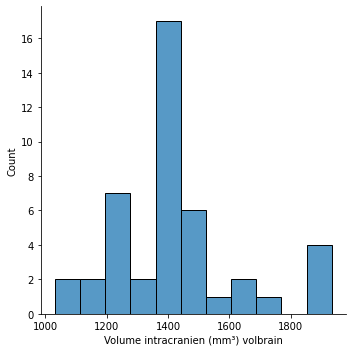

In [72]:
plt.figure(figsize=(6,3))
sns.displot(val, x='Volume intracranien (mm³) volbrain')
plt.show()

<AxesSubplot:xlabel='Volume putamen gauche (mm³) volbrain', ylabel='Volume putamen gauche (mm³) freeview'>

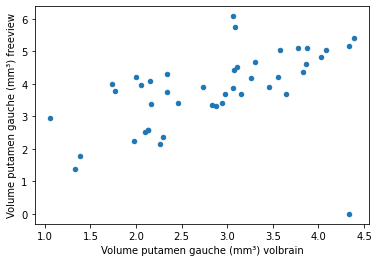

In [29]:
val.plot.scatter(x='Volume putamen gauche (mm³) volbrain',y='Volume putamen gauche (mm³) freeview')

In [81]:
G_SES1=val.filter(like="SES1",axis=0).loc[:,['groupe','Volume intracranien (mm³) volbrain']]
G_SES2=val.filter(like="SES2",axis=0).loc[:,['groupe','Volume intracranien (mm³) volbrain']]

In [83]:
G_SES1.query("groupe == 1")

,groupe,Volume intracranien (mm³) volbrain
NOM,,
APPLINCOURT_MARIE_FRANCE_SES1,1,1248.124
BEDEZ_DIDIER_SES1,1,1482.037
BRISFER_JOEL_SES1,1,1440.171
DEFLANDRE_FRANCOISE_SES1,1,1414.376
DUPONT_JOEL_SES1,1,1474.692
DUTRIAUX_THIERRY_SES1,1,1569.851
EL_KHALDI_AHANNACH_FATIMA_SES1,1,1380.184
JONVEL_SABINE_SES1,1,1333.906
LAURENT_WILLIAMS_SES1,1,1462.195


In [76]:
print(np.size(G_SES1.values),np.shape(G_SES1.values),np.ndim(G_SES1.values))

31 (31, 1) 2


In [78]:
stat,pval=stats.wilcoxon(G_SES1.values[:,0],G_SES2.values[:,0])

ValueError: The samples x and y must have the same length.

In [109]:
GRP1_vol_intracranien=val.query("groupe == 1").loc[:,['Volume intracranien (mm³) volbrain']]
GRP4_vol_intracranien=val.query("groupe == 4").filter(like="SES1",axis=0).loc[:,['Volume intracranien (mm³) volbrain']]

In [110]:
GRP4_vol_intracranien

,Volume intracranien (mm³) volbrain
NOM,
BLANC_GARIN_FREDERIC_SES1,1699.643
BUNIET_PASCAL_SES1,1619.691
CARCAN_JACQUES_SES1,1384.722
COUDRON_PAULE_SES1,1031.087
DALLOY_FREDERIQUE_SES1,1254.771
DIETZINGER_GUY_SES1,1374.178
ERIPRET_CATHERINE_SES1,1411.250
GRAS_SYLVIANE_SES1,1383.897
HUREZ_REGINE_SES1,1217.304


In [141]:
stat,pval=stats.mannwhitneyu(GRP1_vol_intracranien.values[:,0],GRP4_vol_intracranien.values[:,0])
pvalue=pval 
print(pvalue)


0.2594911950390762


<Figure size 432x216 with 0 Axes>

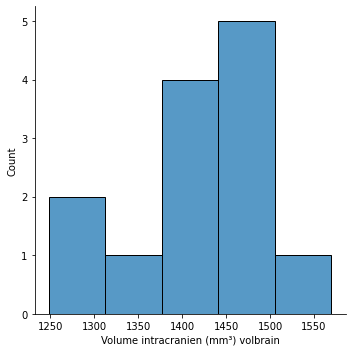

In [130]:
plt.figure(figsize=(6,3))
sns.displot(GRP1_vol_intracranien, x='Volume intracranien (mm³) volbrain')
plt.show()

In [132]:
print("Groupe 1 (mean)",GRP1_vol_intracranien.mean())
print("Groupe 4 (mean)",GRP4_vol_intracranien.mean())

Groupe 1 (mean) Volume intracranien (mm³) volbrain    1413.482
dtype: float64
Groupe 4 (mean) Volume intracranien (mm³) volbrain    1438.3504
dtype: float64


<AxesSubplot:xlabel='Volume intracranien (mm³) volbrain'>

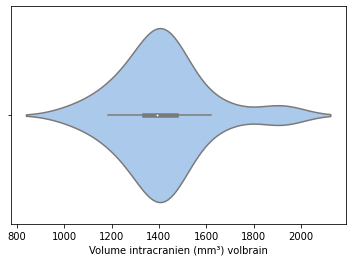

In [144]:
sns.violinplot(data=G_SES1,x='Volume intracranien (mm³) volbrain',split=True,hue="groupe",palette="pastel")

In [ ]:

    stat,pval=stats.mannwhitneyu(val_R2_W36.query("GROUPE == 1")[col].values,val_R2_W36.query("GROUPE == 2")[col].values)
    val_R2_W36['pvalue='] = np.round(pval,3).astype(str)
    print(np.round(pval,3).astype(str))
    plt.figure(figsize=(6,3))
    #print(stats.ttest_ind(test.query("GROUPE == 1")['SN_L'].values,test.query("GROUPE == 2")['SN_L'].values, equal_var=False))    
    sns.violinplot(data=val_R2_W36,y='pvalue=',x=col,split=True,hue="GROUPE",palette="pastel")
    sns.swarmplot(data=val_R2_W36,y='pvalue=',x=col,split=True,hue="GROUPE",palette="bright",alpha=0.8)
    FIG_FILE=os.path.join("/NAS","dumbo","protocoles","FAIRPARKII","W36_DefVsPlac_Median_SN.png")
    plt.savefig(FIG_FILE,dpi=300)
    plt.legend("")
    FIG_FILE=os.path.join("/NAS","dumbo","protocoles","FAIRPARKII","W36_DefVsPlac_Median_wolegend_SN.png")
    plt.savefig(FIG_FILE,dpi=300)
    print("col : ",col,val_R2_W36.shape[0])